In [1]:
import sys, os, json
sys.path.append(os.getcwd())  # 确保能导入当前目录下的模块
from polygen_suite import generate_with_marks
from viz_suite import render_triptych_from_polys, render_triptych_hulls

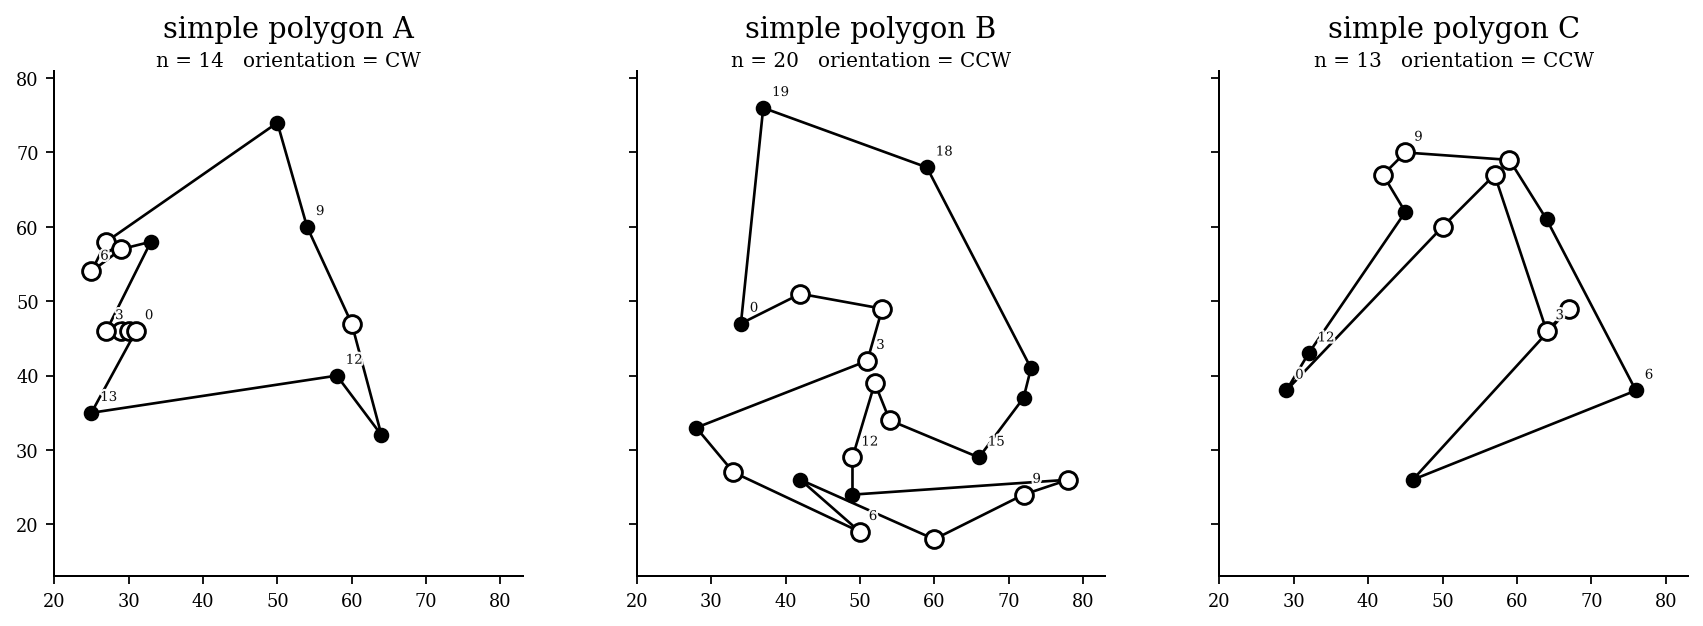

In [2]:
# 生成三类 polygon，并分别获得插入点集合
PolyA, MarkA = generate_with_marks("A")
PolyB, MarkB = generate_with_marks("B")
PolyC, MarkC = generate_with_marks("C")

Polys = [PolyA, PolyB, PolyC]
Marks = [MarkA, MarkB, MarkC]
Polys_Marks = [(PolyA, MarkA), (PolyB, MarkB), (PolyC, MarkC)]

render_triptych_from_polys(Polys_Marks)

In [3]:
def melkman_convex_hull(polygon):
    """
    Melkman's algorithm: convex hull of a simple polygon given in boundary order.
    Input:  polygon -> sequence/deque of (x, y), simple polygon, overall non-collinear
    Output: list of hull vertices in CCW order, without duplicated end point.
    """
    from collections import deque

    # local helpers
    def cross(ax, ay, bx, by): return ax * by - ay * bx
    def orient(a, b, c): return cross(b[0]-a[0], b[1]-a[1], c[0]-a[0], c[1]-a[1])
    def is_left(a, b, c): return orient(a, b, c) > 0.0
    def area2(poly):
        s = 0.0
        for i in range(len(poly)):
            x1, y1 = poly[i]
            x2, y2 = poly[(i + 1) % len(poly)]
            s += cross(x1, y1, x2, y2)
        return s

    pts = deque(polygon)
    n = len(pts)

    # 找到首个非共线三元组以建立初始框架；若找不到则输入不符合要求
    p0, p1 = pts[0], pts[1]
    k, o = 2, 0.0
    while k < n:
        o = orient(p0, p1, pts[k])
        if o != 0.0:
            break
        k += 1

    # 初始化双端队列 D，方向统一为 CCW（允许局部多点共线）
    p2 = pts[k]
    D = deque()
    if o > 0.0:  # p0, p1, p2 is CCW
        D.append(p2); D.append(p0); D.append(p1); D.append(p2)
    else:        # make it CCW by swapping p0,p1
        D.append(p2); D.append(p1); D.append(p0); D.append(p2)

    # 扫描其余点；严格左侧性保证凸性
    used = {0, 1, k}
    order = [i for i in range(n) if i not in used]
    for i in order:
        p = pts[i]
        # 若 p 对上链首边和下链末边均为左侧，则在当前凸包内部，跳过
        if is_left(D[0], D[1], p) and is_left(D[-2], D[-1], p):
            continue
        # 调整上链
        while not is_left(D[0], D[1], p):
            D.popleft()
        D.appendleft(p)
        # 调整下链
        while not is_left(D[-2], D[-1], p):
            D.pop()
        D.append(p)

    # 去尾部重复点；若为顺时针则反转为 CCW
    D.pop()
    hull = list(D)
    if area2(hull) < 0.0:
        hull.reverse()
    return hull

In [4]:
HullA = melkman_convex_hull(PolyA)
HullB = melkman_convex_hull(PolyB)
HullC = melkman_convex_hull(PolyC)

Polys_Hulls = [(PolyA,HullA), (PolyB,HullB), (PolyC,HullC)]

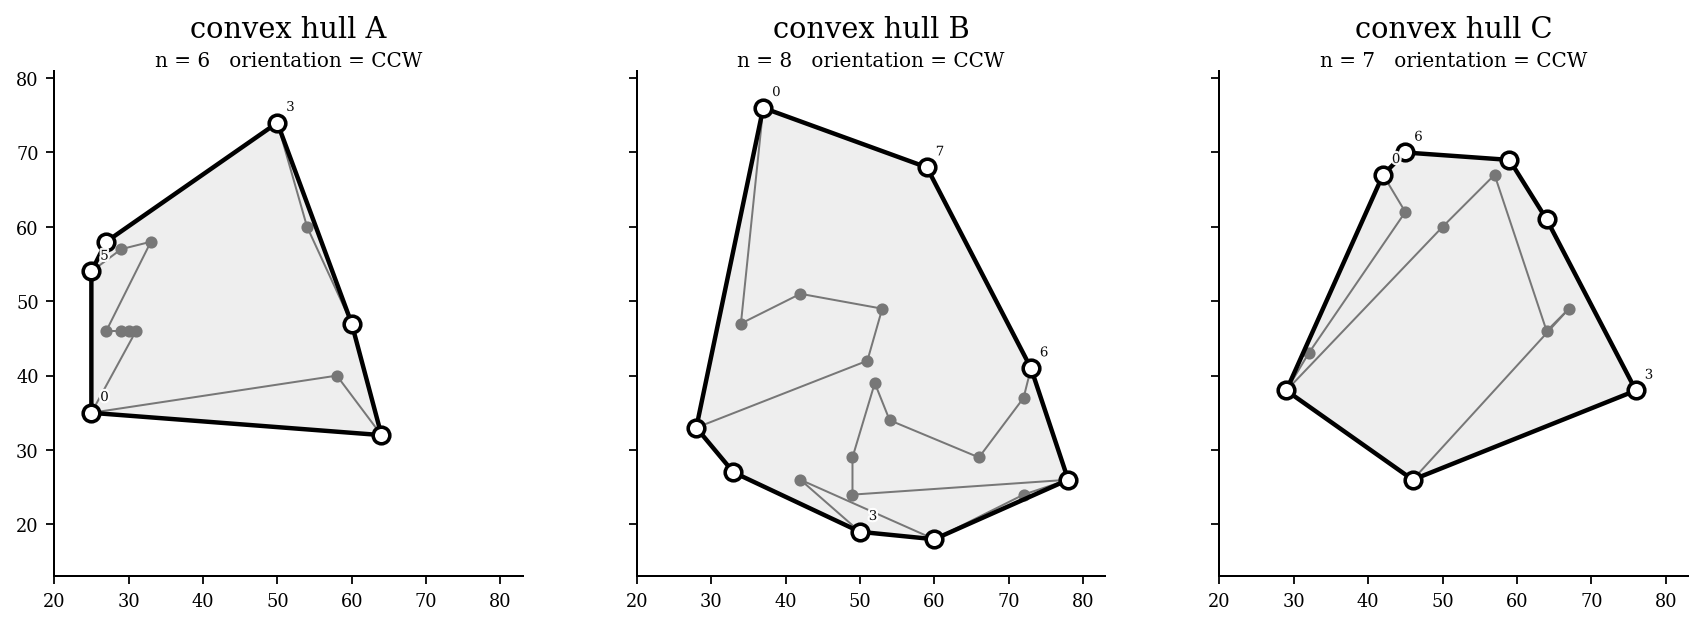

In [5]:
render_triptych_hulls(Polys_Hulls)